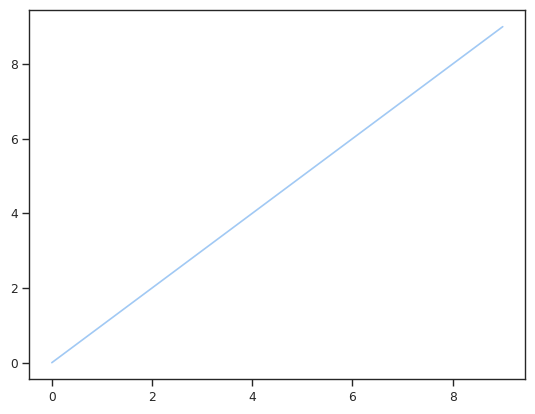

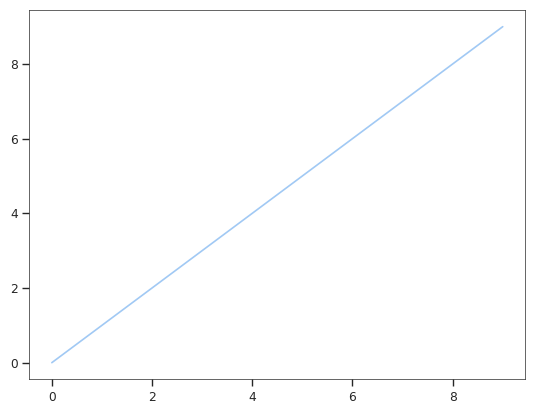

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
#mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer, get_total_parameters
from Plotting.Plot import BasicPlot, MultiPlot
import pandas as pd
import seaborn as sns
import os
colors =   ["#5dd448",
            "#bfa900",
            "#ec742f",
            "#e9496f",
            "#b04ca4",]
palette = sns.color_palette('pastel')
colors = palette.as_hex()

sns.set_style('ticks')
sns.set_context("paper")
plt.figure()
plt.plot(np.arange(10), np.arange(10))
plt.show()
#colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 8
plt.rcParams["axes.linewidth"] = 0.5
plt.figure()
plt.plot(np.arange(10), np.arange(10))
plt.show()
%load_ext autoreload
%autoreload 2

In [65]:
ex_path = "/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment4"
ex_path_kerr8 = "/home/st4eve/Mounts/graham/synthetic_data/Classical_Small_kerr"
ex_path_kerr8_all_weights = '/home/st4eve/Mounts/Classical_Small_kerr_all_weights2'
ex_path_kerr8_classical = '/home/st4eve/Mounts/graham/synthetic_data/Classical_Small_kerr_input_nl'
ex_path_kerr8_2q_high_cuttoff = '/home/st4eve/Mounts/graham/synthetic_data/Classical_Small_kerr_2q_high_cutoff'

def generate_database(ex_path):
    dbGen = ResultsDatabaseGenerator()
    dbGen.initialize_from_folder(ex_path)
    data = dbGen.data
    sample_key = list(data.keys())[0]
    config = data[sample_key]['config']
    config.pop('__doc__', None)
    #config.pop('iteration', None)
    df = pd.DataFrame(columns=config.keys())
    df['iteration'] = np.nan
    for key in data[sample_key]['metrics'].keys():
        df[key] = np.nan
    for i in data.keys():
        config = data[i]['config']
        config.pop('__doc__', None)
        try:
            config['iteration']
        except KeyError:
            config['iteration'] = 1
        if config['iteration'] != -1:
            metrics = data[i]['metrics']
            temp_dict = {}
            for key in metrics.keys():
                temp_dict[key] = metrics[key]
            for key in config.keys():
                temp_dict[key] = config[key]
            df.loc[i] = temp_dict
    if 'num_params' in df.columns:
        df['num_params'] = df['num_params'].apply(lambda x: x[0]).astype(int)
    else:
        df['num_params'] = df.apply(lambda x: get_total_parameters(x['num_qumodes'], x['n_layers']), axis=1)
    df.rename(columns={'accuracy': 'acc', 'val_accuracy': 'val_acc'}, inplace=True)
    return df

df_orig = generate_database(ex_path)
df_kerr8 = generate_database(ex_path_kerr8)
df_kerr8_all_weights = generate_database(ex_path_kerr8_all_weights)
df_kerr8_classical = generate_database(ex_path_kerr8_classical)
df_kerr8_high_cutoff = generate_database(ex_path_kerr8_2q_high_cuttoff)
display(df_kerr8.head())


df_kerr8.loc[df_kerr8['network_type']=='classical']['cutoff'] = -1
df_kerr8_all_weights.loc[df_kerr8_all_weights['network_type']=='classical', 'cutoff'] = -1
df_kerr8_all_weights.loc[df_kerr8_all_weights['network_type']=='classical','num_params'] = 124
df_kerr8_all_weights.loc[df_kerr8_all_weights['network_type']=='quantum','num_params'] = 120
# df_orig.drop_duplicates(subset=['network_type', 'num_qumodes', 'cutoff', 'n_layers', 'iteration', 'num_params'], inplace=True)
df_kerr8.drop_duplicates(subset=['network_type', 'num_qumodes', 'cutoff', 'n_layers', 'num_params', 'iteration'], inplace=True)

Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment4/99 . Ignoring file...
Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment4/153 . Ignoring file...
Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment4/81 . Ignoring file...
Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment4/189 . Ignoring file...
Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment4/170 . Ignoring file...
Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics fil

,cutoff,iteration,n_layers,network_type,num_qumodes,acc,epoch,loss,num_params,val_acc,val_loss
43746,11,6,5,quantum,3,"[0.28999999165534973, 0.3814285695552826, 0.46...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.453689455986023, 1.3784641027450562, 1.3324...",316,"[0.4033333361148834, 0.4466666579246521, 0.446...","[1.3926925659179688, 1.3518368005752563, 1.305..."
43575,-1,19,5,classical,2,"[0.23428571224212646, 0.2785714268684387, 0.32...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.387717604637146, 1.385719656944275, 1.38271...",193,"[0.25333333015441895, 0.2933333218097687, 0.34...","[1.3861559629440308, 1.3859755992889404, 1.379..."
49,9,2,1,quantum,2,"[0.25999999046325684, 0.31142857670783997, 0.3...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.4391298294067383, 1.3879575729370117, 1.367...",120,"[0.3166666626930237, 0.2866666615009308, 0.396...","[1.4009509086608887, 1.375930905342102, 1.3595..."
85,9,2,5,quantum,3,"[0.2628571391105652, 0.4057142734527588, 0.428...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.4373016357421875, 1.3792392015457153, 1.329...",316,"[0.3400000035762787, 0.3266666531562805, 0.496...","[1.3991146087646484, 1.3551892042160034, 1.300..."
38100,5,9,3,quantum,2,"[0.25, 0.2871428430080414, 0.3985714316368103,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.3981094360351562, 1.3749626874923706, 1.358...",156,"[0.24666666984558105, 0.30666667222976685, 0.4...","[1.3814302682876587, 1.3695231676101685, 1.349..."


/tmp/ipykernel_2140670/3149904268.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [66]:
df_kerr8.drop(df_kerr8[df_kerr8['network_type']=='classical'].index, inplace=True)
df_kerr8_all_weights.drop(df_kerr8_all_weights[df_kerr8_all_weights['network_type']=='classical'].index, inplace=True)
df_kerr8_all_weights = pd.concat([df_kerr8_all_weights, df_kerr8_classical], ignore_index=False)
df_kerr8 = pd.concat([df_kerr8, df_kerr8_all_weights], ignore_index=False)
# df_kerr8 = pd.concat([df_kerr8, df_kerr8_high_cutoff], ignore_index=False)

In [67]:
print(len(df_kerr8))
print(df_kerr8['cutoff'].unique())
print(df_kerr8['iteration'].unique())

1001
[11  9  5 -1]
[ 6  2  9 10  1  3  7  8  5  4 27 22 20 21 13 26 24 11 19 14 15 29 30 25
 16 17 18 28 23 12]


Kerr Input 8


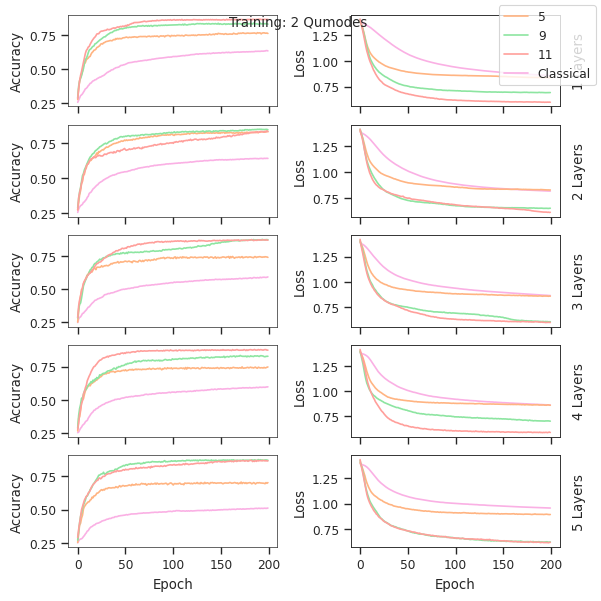

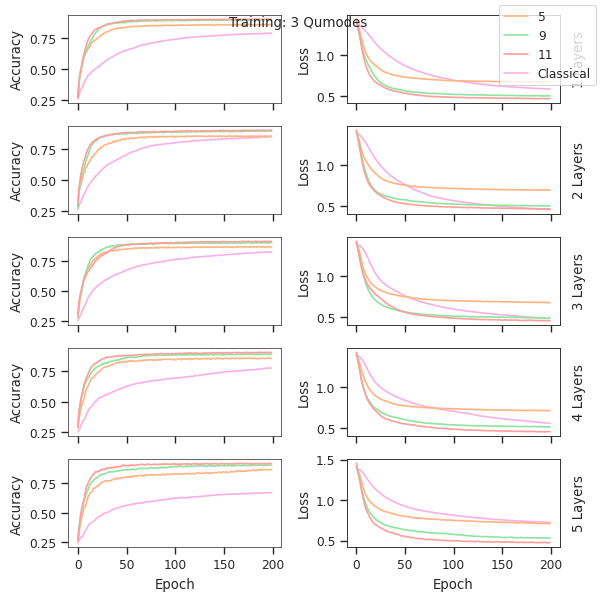

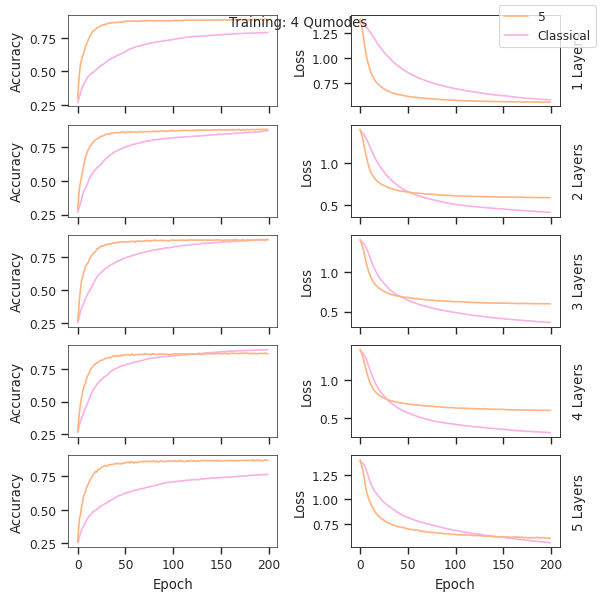

,cutoff,network_type,n_layers,num_qumodes,num_params,acc,val_acc,loss,val_loss,num_exps,raw_data,acc_std,val_acc_std,loss_std,val_loss_std,acc_max,val_acc_max,loss_min,val_loss_min
0,-1,classical,1,1,69.0,"[0.24380952616532645, 0.25566137940795336, 0.2...","[0.25518518575915583, 0.2574074058621018, 0.25...","[1.4154922873885543, 1.3971298844725997, 1.387...","[1.4027574945379186, 1.3902143858097218, 1.383...",27,"[[0.25285714864730835, 0.26428571343421936, 0....","[0.033297032027497925, 0.03171462300568152, 0....","[0.03414244408626211, 0.032575752359454556, 0....","[0.048974284201334206, 0.02247577684095606, 0....","[0.02831833665912492, 0.012397709828851269, 0....","[0.28142857551574707, 0.3142857253551483, 0.32...","[0.3333333432674408, 0.3266666531562805, 0.363...","[1.3642148971557617, 1.3600891828536987, 1.355...","[1.3742831945419312, 1.3721849918365479, 1.358..."
5,-1,classical,2,1,75.0,"[0.2579365107748244, 0.26476190653112197, 0.27...","[0.26296296108652045, 0.2690123446561672, 0.27...","[1.3964134057362874, 1.3877492878172133, 1.382...","[1.3917527463701036, 1.3853841048699838, 1.381...",27,"[[0.29428571462631226, 0.3171428442001343, 0.3...","[0.02675533372350724, 0.04591720782488195, 0.0...","[0.04362516413960557, 0.05161438847073552, 0.0...","[0.04357130614887763, 0.02077528532085384, 0.0...","[0.0294874099805354, 0.014942403919646281, 0.0...","[0.3514285683631897, 0.35857143998146057, 0.37...","[0.38333332538604736, 0.3799999952316284, 0.39...","[1.3761528730392456, 1.3654543161392212, 1.353...","[1.3705986738204956, 1.3571643829345703, 1.346..."
10,-1,classical,3,1,81.0,"[0.2508241774944159, 0.2583516498024647, 0.261...","[0.2635897438113506, 0.26076922909571576, 0.26...","[1.3905764451393714, 1.386199570619143, 1.3835...","[1.3877915694163396, 1.3848455823384798, 1.382...",26,"[[0.23714286088943481, 0.2542857229709625, 0.2...","[0.017896321083433402, 0.021113776236031463, 0...","[0.028792259026986435, 0.02792400553691759, 0....","[0.013457825176429452, 0.009202250200352126, 0...","[0.010283994745153938, 0.00826781511439025, 0....","[0.2928571403026581, 0.31857141852378845, 0.33...","[0.3466666638851166, 0.3466666638851166, 0.346...","[1.3690109252929688, 1.3656675815582275, 1.363...","[1.3660011291503906, 1.3631668090820312, 1.360..."
15,-1,classical,4,1,87.0,"[0.24752747611357614, 0.24807692433779055, 0.2...","[0.2591025640185063, 0.2530769207156621, 0.248...","[1.3875225140498235, 1.3858973200504596, 1.385...","[1.3869116581403291, 1.3858822263204134, 1.385...",26,"[[0.23000000417232513, 0.24142856895923615, 0....","[0.021397627069169225, 0.025379201919990726, 0...","[0.025546299627561306, 0.023892976654019283, 0...","[0.007370828794575076, 0.0038330030815150523, ...","[0.006334880346711917, 0.004361833760524601, 0...","[0.3285714387893677, 0.3471428453922272, 0.328...","[0.3499999940395355, 0.3166666626930237, 0.316...","[1.3816708326339722, 1.3743155002593994, 1.368...","[1.3785382509231567, 1.3731179237365723, 1.367..."
20,-1,classical,5,1,93.0,"[0.238351648243574, 0.24478022123758608, 0.248...","[0.2473076914365475, 0.25397435747660124, 0.25...","[1.3864755813892071, 1.3861552201784575, 1.385...","[1.3861830830574036, 1.3860185467279875, 1.385...",26,"[[0.2328571379184723, 0.2142857164144516, 0.25...","[0.01272022534753789, 0.013394992956624168, 0....","[0.017097489547555963, 0.010043460685846092, 0...","[0.0005033199499324429, 0.0008369305111752983,...","[0.00045016027136049404, 0.0009407626965706336...","[0.25857141613960266, 0.2628571391105652, 0.30...","[0.2633333206176758, 0.28999999165534973, 0.29...","[1.3847236633300781, 1.3821370601654053, 1.379...","[1.384098768234253, 1.3816630840301514, 1.3792..."
1,-1,classical,1,2,124.0,"[0.25566137940795336, 0.27164021023997553, 0.2...","[0.2674074073632558, 0.28012345841637365, 0.29...","[1.3993727895948622, 1.3854879096702293, 1.376...","[1.3909750293802332, 1.3808504033971716, 1.373...",27,"[[0.2314285784959793, 0.2542857229709625, 0.25...","[0.051571644

In [68]:
df_orig.loc[df_orig['network_type']=='classical', 'cutoff'] = 'classical'
df_orig.drop(df_orig[df_orig['cutoff']==1].index, inplace=True)
def process_data(df, groups=['cutoff','network_type', 'n_layers', 'num_qumodes', 'num_params']):
    df_mean = df.groupby(groups).apply(lambda x: pd.DataFrame({
        'acc': [np.mean(x['acc'].tolist(), axis=0)],
        'val_acc': [np.mean(x['val_acc'].tolist(), axis=0)],
        'loss': [np.mean(x['loss'].tolist(), axis=0)],
        'val_loss': [np.mean(x['val_loss'].tolist(), axis=0)],
        'num_exps': [len(x['acc'].tolist())],
        'raw_data':[x['acc'].tolist()]
    }))

    df_std = df.groupby(groups).apply(lambda x: pd.DataFrame({
        'acc_std': [np.std(x['acc'].tolist(), axis=0)],
        'val_acc_std': [np.std(x['val_acc'].tolist(), axis=0)],
        'loss_std': [np.std(x['loss'].tolist(), axis=0)],
        'val_loss_std': [np.std(x['val_loss'].tolist(), axis=0)]
    }))
    df_max = df.groupby(groups).apply(lambda x: pd.DataFrame({
        'acc_max': [np.max(x['acc'].tolist(), axis=0)],
        'val_acc_max': [np.max(x['val_acc'].tolist(), axis=0)],
        'loss_min': [np.min(x['loss'].tolist(), axis=0)],
        'val_loss_min': [np.min(x['val_loss'].tolist(), axis=0)]
    }))
    df_out = pd.concat([df_mean, df_std, df_max], axis=1, ignore_index=False)
    df_out.reset_index(inplace=True)
    df_out.drop(columns=f'level_{len(groups)}', inplace=True)
    df_out.sort_values(['network_type', 'num_qumodes', 'n_layers'], inplace=True)
    return df_out

df_o = process_data(df_orig)
df_k8 = process_data(df_kerr8)
df_k8_all_weights = process_data(df_kerr8_all_weights)

def plot_training_cutoff_sweep(df, fname='cutoff_sweep', dataset='training'):
    os.makedirs(f'./figures/{fname}_plots', exist_ok=True)

    for n in df.loc[df['network_type']=='quantum', 'num_qumodes'].unique():
        df_n = df[df['num_qumodes']==n]
        fig, axs = plt.subplots(ncols=2, nrows=len(df['n_layers'].unique()), figsize=(6,6), sharex=True)
        color_dict = dict(zip(df[df['num_qumodes']==n]['cutoff'].unique(), colors))
        color_dict[-1] = colors[-4]
        for i in df_n.loc[df_n['network_type']=='quantum', 'n_layers'].unique():
            ax2  = axs[i-1,1].twinx()
            ax2.set_yticks([])
            ax2.set_yticklabels([])
            ax2.set_ylabel(f'{i} Layers')
        prefix = 'val_' if dataset=='validation' else '' 
        for i, row in df_n.iterrows():
            idx_row = row['n_layers'] - 1
            epochs = [i for i in range(len(row[prefix+'acc']))]
            axs[idx_row, 0].plot(epochs, row[prefix+'acc'], color=color_dict[row['cutoff']])
            axs[idx_row, 1].plot(epochs, row[prefix+'loss'], color=color_dict[row['cutoff']])
            
            axs[-1,0].set_xlabel('Epoch')
            axs[-1,1].set_xlabel('Epoch')
            axs[idx_row,0].set_ylabel('Accuracy')
            axs[idx_row,1].set_ylabel('Loss')

        color_dict['classical'] = color_dict[-1]
        color_dict.pop(-1)
        for key,val in color_dict.items():
            plt.plot([], [], color=val, label=f'{key}'.capitalize())

        fig.legend()
        fig.tight_layout()
        fig.suptitle(f'{dataset.capitalize()}: {n} Qumodes')
        plt.savefig(f'./figures/{fname}_plots/{fname}_{dataset.capitalize()}_{n}qumodes.png', dpi=300)
        plt.show()

def plot_encoding_comparison(df, fname='encoding comparison', dataset='training'):
    os.makedirs(f'./figures/{fname}_plots', exist_ok=True)
    for n in df.loc[df['network_type']=='quantum', 'num_qumodes'].unique():
        df_n = df[(df['num_qumodes']==n) & (df['network_type']=='quantum')]
        fig, axs = plt.subplots(ncols=2, nrows=len(df_n['n_layers'].unique()), figsize=(6,6), sharex=True, sharey='col')
        color_dict = dict(zip(df_n['encoding'].unique(), colors))
        style_dict = dict(zip(df_n['cutoff'].unique(), ['-', '--', '-.', ':']))
        for i in df_n.loc[df_n['network_type']=='quantum', 'n_layers'].unique():
            ax2  = axs[i-1,1].twinx()
            ax2.set_yticks([])
            ax2.set_yticklabels([])
            ax2.set_ylabel(f'{i} Layers')
        prefix = 'val_' if dataset=='validation' else '' 
        for i, row in df_n.iterrows():
            idx_row = row['n_layers'] - 1
            epochs = [i for i in range(len(row[prefix+'acc']))]
            axs[idx_row, 0].plot(epochs, row[prefix+'acc'], color=color_dict[row['encoding']], linestyle=style_dict[row['cutoff']])
            axs[idx_row, 1].plot(epochs, row[prefix+'loss'], color=color_dict[row['encoding']], linestyle=style_dict[row['cutoff']])
            
            axs[-1,0].set_xlabel('Epoch')
            axs[-1,1].set_xlabel('Epoch')
            axs[idx_row,0].set_ylabel('Accuracy')
            axs[idx_row,1].set_ylabel('Loss')


        for key,val in color_dict.items():
            plt.plot([], [], color=val, label=f'{key}'.capitalize())
        for key,val in style_dict.items():
            plt.plot([], [], color='black', linestyle=val, label=f'{key}'.capitalize())

        fig.legend()
        fig.tight_layout()
        fig.suptitle(f'{dataset.capitalize()}: {n} Qumodes')
        plt.savefig(f'./figures/{fname}_plots/{fname}_{dataset.capitalize()}_{n}qumodes.png', dpi=300)
        plt.show()

#plot_training_cutoff_sweep(df_o, 'cutoff_sweep', dataset='validation')
# plot_training_cutoff_sweep(df_k, 'cutoff_sweep_kerr', dataset='validation')

print('Kerr Input 8')
plot_training_cutoff_sweep(df_k8, 'cutoff_sweep_kerr8')
display(df_k8)

encodings = {'displacement': df_orig, 'kerr': df_kerr8}
df_full = pd.concat(encodings, names=['encoding'])
df_f = process_data(df_full, groups=['encoding', 'network_type', 'n_layers', 'num_qumodes', 'num_params', 'cutoff'])

#plot_encoding_comparison(df_f, 'encoding_comparison', dataset='training')


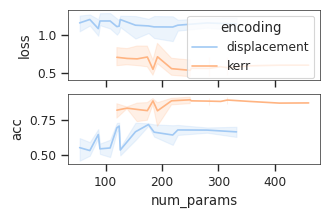

In [69]:

def generate_averaged_database(df):
    df_mean = copy.deepcopy(df)
    df_mean['acc'] = df_mean['acc'].apply(lambda x: x[-1])
    df_mean['acc_max'] = df_mean['acc_max'].apply(lambda x: x[-1])
    df_mean['acc_std'] = df_mean['acc_std'].apply(lambda x: x[-1])
    df_mean['acc_max_std'] = df_mean['acc_std'] 
    df_mean['val_acc'] = df_mean['val_acc'].apply(lambda x: x[-1])
    df_mean['val_acc_std'] = df_mean['val_acc_std'].apply(lambda x: x[-1])
    df_mean['val_acc_max'] = df_mean['val_acc_max'].apply(lambda x: x[-1])
    df_mean['loss'] = df_mean['loss'].apply(lambda x: x[-1])
    df_mean['loss_std'] = df_mean['loss_std'].apply(lambda x: x[-1])
    df_mean['loss_min'] = df_mean['loss_min'].apply(lambda x: x[-1])
    df_mean['val_loss'] = df_mean['val_loss'].apply(lambda x: x[-1])
    df_mean['val_loss_min'] = df_mean['val_loss_min'].apply(lambda x: x[-1])
    df_mean['val_loss_std'] = df_mean['val_loss_std'].apply(lambda x: x[-1])
    df_mean['acc_ratio'] = df_mean['acc']/df_mean['num_params']
    df_mean['acc_ratio_std'] = df_mean['acc_std']/df_mean['num_params']
    df_mean['val_acc_ratio'] = df_mean['val_acc']/df_mean['num_params']
    df_mean['val_acc_ratio_std'] = df_mean['val_acc_std']/df_mean['num_params']
    df_mean['loss_ratio'] = df_mean['loss']/df_mean['num_params']
    df_mean['loss_ratio_std'] = df_mean['loss_std']/df_mean['num_params']
    df_mean['val_loss_ratio'] = df_mean['val_loss']/df_mean['num_params']
    df_mean['val_loss_ratio_std'] = df_mean['val_loss_std']/df_mean['num_params']
    df_mean.sort_values('num_params')
    return df_mean

def plot_acc_per_param(df, fname='AccPerParam', cutoffs=[3,7,9,'classical']):
    color_dict = dict(zip(cutoffs, colors))
    color_dict['classical'] = colors[-1]
    metrics = ['acc', 'loss']
    axs_labels_dict = dict(zip(metrics, ['Accuracy', 'Loss', 'Accuracy', 'Loss']))
    for n in df['num_qumodes'].unique():
        fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6,6), sharex=True)
        axs_dict = dict(zip(metrics, axs.flatten()))
        for cutoff in cutoffs:
            row = df.loc[(df['num_qumodes']==n) & (df['cutoff']==cutoff)]
            for metric in metrics:
                axs_dict[metric].errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
                axs_dict[metric].plot(row['num_params'].values, row[metric].values, '--', color=color_dict[cutoff], alpha=0.8)


        for key,val in color_dict.items():
            plt.plot([], [], color=val, label=f'{key}'.capitalize())

        # ax2  = axs[0].twinx()
        # ax2.set_yticks([])
        # ax2.set_yticklabels([])
        # ax2.set_ylabel(f'Training') 
    
        # ax2  = axs[1].twinx()
        # ax2.set_yticks([])
        # ax2.set_yticklabels([])
        # ax2.set_ylabel(f'Testing')   

        fig.legend()
        fig.supxlabel('Number of Parameters')
        fig.suptitle(f'{n} Qumodes')

        for key, val in axs_labels_dict.items():
            axs_dict[key].set_ylabel(val)
        fig.tight_layout()
        plt.savefig(f'cutoff_sweep_plots/{fname}_AccPerParam_{n}qumodes.png', dpi=300)
        plt.show()


    fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6,6), sharex=True)
    axs_dict = dict(zip(metrics, axs.flatten()))
    axs[0].axvline(x=df[df['num_qumodes']==4]['num_params'].min(), color='k', linestyle='--')
    axs[0].axvline(x=df[df['num_qumodes']==4]['num_params'].max(), color='k', linestyle='--')
    axs[0].axvline(x=df[df['num_qumodes']==3]['num_params'].min(), color='b', linestyle='--')
    axs[0].axvline(x=df[df['num_qumodes']==3]['num_params'].max(), color='b', linestyle='--')
    axs[0].axvline(x=df[df['num_qumodes']==2]['num_params'].min(), color='r', linestyle='--')
    axs[0].axvline(x=df[df['num_qumodes']==2]['num_params'].max(), color='r', linestyle='--')
    for cutoff in cutoffs:
            row = copy.deepcopy(df[(df['cutoff']==cutoff)])
            row.sort_values('num_params', inplace=True)
            for metric in metrics:
                #axs_dict[metric].errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
                axs_dict[metric].plot(row['num_params'].values, row[metric].values, '-', marker='.', color=color_dict[cutoff], alpha=0.8)

    for key,val in color_dict.items():
        plt.plot([], [], color=val, label=f'{key}'.capitalize())

    # ax2  = axs[1].twinx()
    # ax2.set_yticks([])
    # ax2.set_yticklabels([])
    # ax2.set_ylabel(f'Training') 

    # ax2  = axs[1].twinx()
    # ax2.set_yticks([])
    # ax2.set_yticklabels([])
    # ax2.set_ylabel(f'Testing')   

    fig.legend()
    fig.supxlabel('Number of Parameters')
    fig.suptitle(f'All Qumodes')
    for key, val in axs_labels_dict.items():
        axs_dict[key].set_ylabel(val)
    fig.tight_layout()
    plt.savefig(f'cutoff_sweep_plots/{fname}_AccPerParam_allqumodes.png', dpi=300)
    plt.savefig(f'cutoff_sweep_plots/{fname}_AccPerParam_allqumodes.svg')
    plt.show()
    
    
    # fig, axs = plt.subplots(figsize=(6,6), sharex=True)
    # metric = 'val_acc'
    # for cutoff in cutoffs:
    #     row = copy.deepcopy(df[(df['cutoff']==cutoff)])
    #     row.sort_values('num_params', inplace=True)
    #     #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
    #     axs.plot(row['num_params'].values, row[metric].values, '-', color=color_dict[cutoff], alpha=0.8)

    # for key in cutoffs:
    #     plt.plot([], [], color=color_dict[key], label=f'{key}'.capitalize()) 

    # fig.legend()
    # fig.supxlabel('Number of Parameters')
    # axs.set_ylabel('Validation Accuracy')
    # fig.tight_layout()
    # plt.savefig(f'cutoff_sweep_plots/{fname}_AccLarg_allqumodes.png', dpi=300)
    # plt.show()


    
    

df_o_mean = generate_averaged_database(df_o)
df_k8_mean = generate_averaged_database(df_k8)
df_k8_all_weights_mean = generate_averaged_database(df_k8_all_weights)

#plot_acc_per_param(df_o_mean, 'cutoff_sweep', cutoffs=[5,3, 7, 9, 'classical'])
#plot_acc_per_param(df_k_mean, 'cutoff_sweep_kerr', cutoffs=[5,10,'classical'])
#plot_acc_per_param(df_k8_mean, 'cutoff_sweep_kerr8', cutoffs=[5,'classical'])


# def plot_comparison(metric, ylabel='Validation Accuracy'):
#     fig, axs = plt.subplots(figsize=(6,6), sharex=True)
#     color_dict = dict(zip([5,7,10,'classical'], colors))
#     for cutoff in [7,'classical']:
#         row = copy.deepcopy(df_o_mean[(df_o_mean['cutoff']==cutoff)])
#         row.sort_values('num_params', inplace=True)
#         #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
#         axs.plot(row['num_params'].values, row[metric].values, '--', color=color_dict[cutoff], alpha=0.8)
#         #axs.fill_between(row['num_params'].values, row[metric]-row[f'{metric}_std'], row[metric]+row[f'{metric}_std'], color=color_dict[cutoff], alpha=0.1)
#     for cutoff in [10,'classical']:
#         row = copy.deepcopy(df_k_mean[(df_k_mean['cutoff']==cutoff)])
#         row.sort_values('num_params', inplace=True)
#         #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
#         axs.plot(row['num_params'].values, row[metric].values, '--', color=color_dict[cutoff], alpha=0.8)
#         #axs.fill_between(row['num_params'].values, row[metric]-row[f'{metric}_std'], row[metric]+row[f'{metric}_std'], color=color_dict[cutoff], alpha=0.1)

#     def legend(label, color, linestyle='-', marker=''):
#         plt.plot([],[], color=color, ls=linestyle, marker=marker, label=label.capitalize())
#         return

# plot_comparison('val_acc', 'Validation Accuracy')
# plot_comparison('loss', 'Loss')

df_f_mean = generate_averaged_database(df_f)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3.25, 2), sharex=True)
sns.lineplot(df_f_mean[df_f_mean['network_type']=='quantum'], x='num_params', y='loss', hue='encoding', markers=True, dashes=False, ax=ax[0])
sns.lineplot(df_f_mean[df_f_mean['network_type']=='quantum'], x='num_params', y='acc', hue='encoding', markers=True, dashes=False, ax=ax[1], legend=None)
plt.savefig('figures/encoding_comparison.svg')

# Accuracy Violin Plots

In [70]:
def pd_last_epoch(df):
    df_out = copy.deepcopy(df)
    df_out['acc'] = df_out['acc'].apply(lambda x: x[-1])
    df_out['val_acc'] = df_out['val_acc'].apply(lambda x: x[-1])
    df_out['loss'] = df_out['loss'].apply(lambda x: x[-1])
    df_out['val_loss'] = df_out['val_loss'].apply(lambda x: x[-1])
    df_out['epoch'] = df_out['epoch'].apply(lambda x: x[-1])
    return df_out

encodings = {'displacement': df_orig, 'kerr8': df_kerr8}
df_full = pd.concat(encodings, names=['encoding'])
df_full = df_full.reset_index(level=0)
df_f_stat = pd_last_epoch(df_full)
pd.to_pickle(df_full, './dataframes/df_full.pkl')
df_f = process_data(df_full, groups=['network_type', 'n_layers', 'num_qumodes', 'num_params', 'cutoff', 'encoding'])
df_f_mean = generate_averaged_database(df_f)
df_o_stat = pd_last_epoch(df_orig)
df_k8_stat = pd_last_epoch(df_kerr8)
df_k8_stat_all_weights = pd_last_epoch(df_kerr8_all_weights)
df_f_stat_quantum = copy.deepcopy(df_f_stat[df_f_stat['network_type'] == 'quantum'])
df_f_stat_quantum['cutoff'] = df_f_stat_quantum['cutoff'].apply(pd.to_numeric)
df_o_stat_quantum = copy.deepcopy(df_o_stat[df_o_stat['network_type'] == 'quantum'])
df_o_stat_quantum['cutoff'] = df_o_stat_quantum['cutoff'].apply(pd.to_numeric)
df_k8_stat_quantum = copy.deepcopy(df_k8_stat[df_k8_stat['network_type'] == 'quantum'])
df_k8_stat_quantum = df_k8_stat_quantum['cutoff'].apply(pd.to_numeric)



/tmp/ipykernel_2140670/3858813889.py:10: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
/tmp/ipykernel_2140670/3858813889.py:29: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.


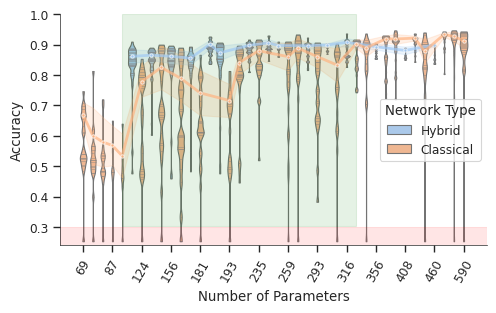

0.8633333444595337


/tmp/ipykernel_2140670/3858813889.py:62: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.


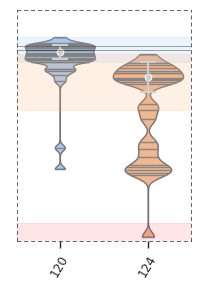

In [77]:
df_k8_stat = pd_last_epoch(df_kerr8)
df_k8_stat.drop_duplicates(subset=['network_type', 'num_qumodes', 'cutoff', 'n_layers', 'num_params', 'acc'], inplace=True)
df_k8_stat['num_params'] = df_k8_stat['num_params'].apply(lambda x: x).astype(int)
df_k8_stat.loc[df_k8_stat['network_type']=='classical', 'cutoff'] = -1



n = 3
fig1 = plt.figure(figsize=(5.5,3))
ax1 = sns.violinplot(df_k8_stat, x='num_params', y='val_acc', hue='network_type', 
               hue_order=['quantum', 'classical'], width=0.8, bw_method=0.1, inner='stick', split=False, cut=0, linewidth=0.8,
               palette=palette,
               density_norm='count', inner_kws={'color': 'grey', 'alpha':0.7})
sns.despine(offset=0)

df_k8_m_plot = copy.deepcopy(df_k8_stat)
try:
    df_k8_m_plot.drop(columns=['model', 'exp_folder'], inplace=True)
except:
    pass
df_k8_m_plot.drop(columns=['epoch'], inplace=True)
mean_accuracy = df_k8_m_plot.groupby(['num_params', 'network_type'])['val_acc'].transform('mean')
df_k8_m_plot = df_k8_m_plot[df_k8_m_plot['val_acc'] >= mean_accuracy]
df_k8_m_plot.sort_values('num_params', inplace=True)
df_k8_m_plot['index'] = pd.factorize(df_k8_m_plot['num_params'])[0]

index_dict = dict(zip(df_k8_m_plot['num_params'].unique(), df_k8_m_plot['index'].unique()))

sns.lineplot(df_k8_m_plot, x='index', y='val_acc', 
             #style='network_type', 
             hue='network_type',
             linewidth=2,
             marker='.',
             palette=palette,
             hue_order=['quantum', 'classical'],
             style_order=['quantum', 'classical'], 
             errorbar='sd',
             alpha=0.7,
             legend=None)

#plt.axhline(y=0.3, color='k', linestyle='--')
plt.axvspan(index_dict[120]-1, index_dict[316]+1, ymin=0.085, alpha=0.1, color='green')
plt.axhspan(0.0, 0.3, xmin=0.0, alpha=0.1, color='red')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Number of Parameters')
plt.ylim(0.24, 1.0)
ax1.legend_.set_title('Network Type')
handles, labels = ax1.get_legend_handles_labels()
labels = ['Hybrid', 'Classical']
ax1.legend(handles, labels, title='Network Type')

[l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_major_ticks()) if i % n != 0]
plt.xticks(rotation=60)
plt.savefig('./figures/kerr_encoding_violinplot.svg')
plt.show()

cl_nparams = 124
q_nparams = 120

fig= plt.figure(figsize=(2.25,3))

ax1 = sns.violinplot(df_k8_stat[(df_k8_stat['num_params'] == q_nparams) | (df_k8_stat['num_params']== cl_nparams)], x='num_params', y='val_acc', hue='network_type', legend=None, 
               hue_order=['quantum', 'classical'], width=0.8, bw_method=0.1, inner='stick', split=False, cut=0, palette=palette,
               density_norm='count', inner_kws={'lw': 1, 'color': 'grey', 'alpha':0.9}, native_scale=True)

palette_temp = [palette[-3] for i in range(2)]
sns.lineplot(df_k8_m_plot[(df_k8_m_plot['num_params'] == q_nparams) | (df_k8_m_plot['num_params']== cl_nparams)], x='num_params', y='val_acc', hue='network_type', legend=None,
                hue_order=['quantum', 'classical'], alpha=1.0, marker='o', err_style='bars', errorbar='sd', err_kws={'capsize': 6, 'elinewidth': 1.5, 'capthick': 1.5}, palette=palette_temp)
plt.axhspan(ymin=df_k8_m_plot[df_k8_m_plot['num_params']==q_nparams]['val_acc'].min(), 
            ymax=df_k8_m_plot[df_k8_m_plot['num_params']==q_nparams]['val_acc'].max(), 
            color=palette[0], alpha=0.2)
plt.axhspan(ymin=df_k8_m_plot[df_k8_m_plot['num_params']==cl_nparams]['val_acc'].min(), 
            ymax=df_k8_m_plot[df_k8_m_plot['num_params']==cl_nparams]['val_acc'].max(), 
            color=palette[1], alpha=0.2)
plt.axhspan(ymin=0, ymax=0.3, color='red', alpha=0.1)


for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_linestyle((0, (5, 5)))
index_dict = dict(zip(df_k8_m_plot['num_params'].unique(), df_k8_m_plot['index'].unique()))
plt.ylim(0.24,1.0)
plt.axhline(df_k8_stat_all_weights[df_k8_stat_all_weights['num_params']==q_nparams]['val_acc'].median(), color='k', alpha=0.5, lw=0.5)
print(df_k8_stat.loc[[309,]]['val_acc'].values[0])
df_k8_temp = df_k8_stat
df_k8_temp = df_k8_temp[df_k8_temp['num_params'] == cl_nparams]
df_k8_temp = df_k8_temp[df_k8_temp['acc'] > df_k8_temp['acc'].mean()]
plt.axhline(df_k8_temp['val_acc'].median(), color='k', alpha=0.5, lw=0.5)

plt.yticks([])
plt.xticks([q_nparams,cl_nparams],[q_nparams,cl_nparams])
plt.xticks(rotation=60)
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'./figures/kerr_encoding_violinplot_{q_nparams}_{cl_nparams}.svg')
plt.show()

# Generate timing plots

In [31]:
# from common_packages.calc_time import calc_time, generate_time_database, calc_time_per_epoch, find_max_time
# import seaborn as sns
# def generate_time_df(ex_path):
#     time_data = generate_time_database(ex_path) 
#     df_time = pd.DataFrame(columns=time_data[1]['config'].keys())
#     df_time['time'] = np.nan
#     df_time.pop('__doc__')
#     for exp, val in time_data.items():
#         config = val['config']
#         config.pop('__doc__', None)
#         if config['iteration'] != -1:
#             time = val['time']
#             df_time.loc[exp] = [*config.values(), time] 
#     df_time.pop('iteration')
#     df_time.loc[df_time['network_type']=='classical', 'cutoff'] = 0
#     df_time['time'] = df_time['time'] / np.timedelta64(1,'h')
#     df_time_mean = df_time.groupby(['network_type', 'n_layers', 'num_qumodes', 'cutoff']).mean()
#     df_time_mean.reset_index(inplace=True)
#     display(df_time.head())
#     # display(df_time_mean.head())
#     display(df_time.describe())
#     display(df_time_mean.describe())
#     return df_time, df_time_mean

# df_time_orig, df_time_mean_orig = generate_time_df('/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep')
# df_time_kerr, df_time_mean_kerr = generate_time_df('/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Kerr')

# def plot_time_violin(df, fname='time_violin'):
#     sns.violinplot(df[df['network_type']=='quantum'], x='n_layers', hue='num_qumodes', y='time', bw=0.4, cut=True)
#     plt.show()
#     sns.violinplot(df[df['network_type']=='quantum'], hue='num_qumodes', x='cutoff', y='time', bw=0.4, cut=True)
#     plt.show()
#     sns.scatterplot(df[df['network_type']=='classical'], hue='num_qumodes', x='n_layers', y='time')
#     plt.show()
#     print('Correlation Matrix')
#     display(df.corr())

# plot_time_violin(df_time_mean_orig, 'time_violin_orig')
# plot_time_violin(df_time_mean_kerr, 'time_violin_kerr')
# print(df_o['num_exps'].describe())
# sns.histplot(df_o, x='num_exps', hue='network_type')
# sns.displot(df_time_mean_orig[df_time_mean_orig['network_type']=='quantum'], x='time', hue='num_qumodes', kind='kde', cut=0, fill=True)
# sns.displot(df_time_mean_kerr[df_time_mean_kerr['network_type']=='quantum'], x='time', hue='num_qumodes', kind='kde', cut=0, fill=True)

In [32]:
import numpy as np
from quantum_base import Net as Net_orig
from quantum_base import OPTIMIZER, LOSS_FUNCTION
from quantum_base_kerr import Net as Net_kerr
from data import generate_synthetic_dataset_easy
import seaborn as sns
from itertools import product
test_data, validate_data = generate_synthetic_dataset_easy(num_datapoints=1000, n_features=8, n_classes=4)


df_orig['model'] = Net_orig
df_orig['exp_folder'] = '/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep/'
df_kerr8['model'] = Net_kerr
df_kerr8['exp_folder'] = ex_path_kerr8 + '/'
def plot_network_certainty_dist(df, metric='acc', fname='network_certainty_dist', validate_data=validate_data):  
    df_final = copy.deepcopy(df)
    df_final[metric] = df[metric].apply(lambda x: x[-1])
    df_quantum = df_final[df_final['network_type']=='quantum']
    df_quantum = df_quantum[df_quantum['num_qumodes']==2]
    df_classical = df_final[df_final['network_type']=='classical']

    exp_folder = df_quantum['exp_folder'].unique()[0]
 
    for n in df_quantum['num_qumodes'].unique():
        for c in df_quantum[df_quantum['num_qumodes']==n]['cutoff'].unique():
            for nl in df_quantum.loc[(df_quantum['num_qumodes']==n) & (df_quantum['cutoff']==c)]['n_layers'].unique():
                exp_quantum = df_quantum.loc[(df_quantum['num_qumodes']==n) & (df_quantum['cutoff']==c) & (df_quantum['n_layers']==nl)][metric]
                exp_classical = df_classical.loc[(df_classical['num_qumodes']==n) & (df_classical['n_layers']==nl)][metric]
                if len(exp_quantum) == 0 or len(exp_classical) == 0:
                    continue
                else:
                    exp_quantum = exp_quantum.idxmax()
                    exp_classical = exp_classical.idxmax()
                    print('For Number of Qumodes: ', n, ' Cutoff: ', c, ' Layers: ', nl)
                    print(f'Highest Accuracy Experiments\nQuantum: {exp_quantum} \nClassical: {exp_classical}')
                    print(f'Val Acc Quantum: {df_quantum.loc[exp_quantum, "val_acc"][-1]}')
                    model = df_final['model'][exp_quantum](
                        network_type='quantum',
                        num_qumodes=n,
                        n_layers=nl,
                        cutoff=c,
                        max_initial_weight=0.15
                    )
                    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
                    output_quantum = model(validate_data[0][0:1])
                    try:
                        model.load_weights(f'{exp_folder}{exp_quantum}/weights/weight99.ckpt', by_name=False).expect_partial()
                    except:
                        model.load_weights(f'{exp_folder}{exp_quantum}/weights/weight.99.ckpt', by_name=False).expect_partial()
                    output_quantum = model(validate_data[0])

                    #loss_quantum, acc_quantum = model.evaluate(validate_data[0], validate_data[1])

                    model_classical = df_final['model'][exp_classical](
                        network_type='classical',
                        num_qumodes=n,
                        n_layers=nl,
                        cutoff=1,
                        max_initial_weight=0.15
                    )

                    model_classical.load_weights(f'{exp_folder}{exp_classical}/weights/weight99.ckpt', by_name=False).expect_partial()
                    model_classical.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
                    output_classical = model_classical(validate_data[0])

                    #loss_classical, acc_classical = model_classical.evaluate(validate_data[0], validate_data[1])
                    
                    plot_df = pd.DataFrame(columns=['Quantum', 'Classical'])
                    plot_df['Quantum']=np.max(output_quantum, axis=1)
                    plot_df['Classical']=np.max(output_classical, axis=1)

                    print(f'Average Maximum Output Probability\nQuantum: {np.mean(np.max(output_quantum, axis=1))}\nClassical: {np.mean(np.max(output_classical, axis=1))}')
                    sns.displot(plot_df)
                    plt.xlabel(f'Maximum Output Probability')
                    plt.title(f'Certainty Distribution\n{metric.capitalize()} {n} Qumodes {c} Cutoff {nl} Layers')
                    plt.show()


plot_network_certainty_dist(df_kerr8[(df_kerr8['num_qumodes']==2) & (df_kerr8['n_layers']==1) & ( (df_kerr8['cutoff']==5) | (df_kerr8['cutoff']=='classical') )], validate_data=validate_data)

In [33]:
plot_network_certainty_dist(df_orig, validate_data=validate_data, metric='acc')

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,class
0,3.298863,2.381539,-1.205030,6.605331,2.113865,4.691736,3.900598,-2.447516,3
1,-1.872740,-1.655000,0.085481,3.598689,-2.387423,-6.949945,3.784349,1.492308,1
2,6.935569,-0.177929,2.256126,-5.588208,4.427367,5.075146,-3.620722,-1.539120,3
3,-5.382906,-1.133503,4.566957,5.206033,-4.497660,-6.731853,0.433409,4.236264,1
4,2.684470,3.886234,3.923193,-2.050238,-0.871740,-0.343404,3.408071,-3.257353,2


,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,class
feature 1,1.000000,0.117481,-0.424462,-0.419638,0.000040,0.278215,0.423869,-0.479970,-0.138790
feature 2,0.117481,1.000000,0.328440,0.261661,0.124705,0.151272,-0.044040,-0.240802,-0.112911
feature 3,-0.424462,0.328440,1.000000,0.349037,0.102656,-0.181656,-0.337930,0.151171,-0.018838
feature 4,-0.419638,0.261661,0.349037,1.000000,0.107459,0.068298,-0.039066,0.320556,-0.143571
feature 5,0.000040,0.124705,0.102656,0.107459,1.000000,0.269996,-0.139325,-0.219774,0.073145
feature 6,0.278215,0.151272,-0.181656,0.068298,0.269996,1.000000,-0.093505,0.085975,0.196382
feature 7,0.423869,-0.044040,-0.337930,-0.039066,-0.139325,-0.093505,1.000000,-0.266368,-0.377516
feature 8,-0.479970,-0.240802,0.151171,0.320556,-0.219774,0.085975,-0.266368,1.000000,0.144904
class,-0.138790,-0.112911,-0.018838,-0.143571,0.073145,0.196382,-0.377516,0.144904,1.000000


/tmp/ipykernel_2140670/1687866382.py:59: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.scatterplot(df_data, x='feature 1', y='feature 6', hue='class', palette=palette_temp, s=3.0, ax=ax)
/tmp/ipykernel_2140670/1687866382.py:59: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.scatterplot(df_data, x='feature 1', y='feature 6', hue='class', palette=palette_temp, s=3.0, ax=ax)
/tmp/ipykernel_2140670/1687866382.py:59: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.scatterplot(df_data, x='feature 1', y='feature 6', hue='class', palette=palette_temp, s=3.0, ax=ax)
/tmp/ipykernel_2140670/1687866382.py:59: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.scatterplot(df_data, x='feature 1', y='feature 6', hue='class', palette=palette_temp, s=3.0, ax=ax)


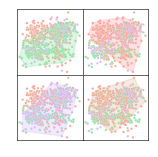

In [34]:
import numpy as np
from quantum_base import Net as Net_orig
from quantum_base import OPTIMIZER, LOSS_FUNCTION
from quantum_base_kerr import Net as Net_kerr
from data import generate_synthetic_dataset_easy_raw, generate_synthetic_dataset_easy
import seaborn as sns
import tensorflow as tf
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
from itertools import product
import fnmatch
import os
from scipy.spatial import ConvexHull

def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

train_data, validate_data = generate_synthetic_dataset_easy_raw(num_datapoints=1000, n_features=8, n_classes=4)
x_train, y_train = train_data
x_val, y_val = validate_data

columns = [f'feature {i+1}' for i in range(8)] + ['class']
df_data = pd.DataFrame(columns=columns)
df_data['class'] = y_train + 1
df_data[columns[:-1]] = x_train

display(df_data.head())
display(df_data.corr())

palette_temp = palette[2:8]

# sns.pairplot(df_data, hue='class', palette=palette_temp, kind='scatter')
# plt.show()
# df_data_fake = pd.DataFrame(columns=['feature 1', 'feature 2', 'class'])
# cluster1 = np.random.multivariate_normal([-1,-1], [[0.2,0],[0,0.2]], 1000)
# cluster2 = np.random.multivariate_normal([1,1], [[0.2,0],[0,0.2]], 1000)
# cluster3 = np.random.multivariate_normal([-1,1], [[0.2,0],[0,0.2]], 1000)
# cluster4 = np.random.multivariate_normal([1,-1], [[0.2,0],[0,0.2]], 1000)

# df_data_fake['feature 1'] = np.concatenate([cluster1[:,0], cluster2[:,0], cluster3[:,0], cluster4[:,0]])
# df_data_fake['feature 2'] = np.concatenate([cluster1[:,1], cluster2[:,1], cluster3[:,1], cluster4[:,1]])
# df_data_fake['class'] = np.concatenate([np.ones(1000), np.ones(1000)*2, np.ones(1000)*3, np.ones(1000)*4])
# df_data_fake['class'] = df_data_fake['class'].apply(int)
# fig = plt.figure(figsize=(1.3,1.3))
# ax1 = sns.scatterplot(df_data_fake, x='feature 1', y='feature 2', hue='class', palette=palette_temp, s=3.0)
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1.08))
# plt.savefig('./figures/sample_data.svg', dpi=300, bbox_inches='tight')
# plt.show()


fig, axs = plt.subplots(2,2, figsize=(1.7,1.7), sharex=True, sharey=True)
axs = axs.flatten()
for i,ax in enumerate(axs):
    ax = sns.scatterplot(df_data, x='feature 1', y='feature 6', hue='class', palette=palette_temp, s=3.0, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    encircle(df_data[df_data['class']==i+1]['feature 1'], df_data[df_data['class']==i+1]['feature 6'], ax=ax, fc=palette_temp[i], ec=palette_temp[i], alpha=0.3)
plt.subplots_adjust(wspace=0, hspace=0)
#sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1.08))
plt.savefig('./figures/real_data.svg', dpi=300, bbox_inches='tight')

In [51]:
df_orig['model'] = Net_orig
df_orig['exp_folder'] = ex_path + '/' 
df_kerr8['model'] = Net_kerr
df_kerr8['exp_folder'] = ex_path_kerr8 + '/' 
df_kerr8_all_weights['model'] = Net_kerr
df_kerr8_all_weights['exp_folder'] = ex_path_kerr8_all_weights + '/'
df_kerr8_all_weights.loc[df_kerr8_all_weights['network_type']=='classical', 'exp_folder'] = ex_path_kerr8_classical + '/'

df_kerr8.loc[df_kerr8['network_type']=='classical', 'exp_folder'] = ex_path_kerr8_classical + '/'

OPTIMIZER = tf.keras.optimizers.legacy.Adam()


pd.to_pickle(df_kerr8, './dataframes/df_kerr8.pkl', compression='xz')

from quantum_base_kerr import train_data, test_data
validate_data = test_data
def plot_network_output_dist(df, metric='acc', fname='network_certainty_dist', validate_data=validate_data, epoch=99):  
    df_final = copy.deepcopy(df)
    df_final[metric] = df[metric].apply(lambda x: x[-1])
    df_quantum = df_final[df_final['network_type']=='quantum']
    df_quantum = df_quantum[df_quantum['num_qumodes']==2]
    df_classical = df_final[df_final['network_type']=='classical']
    df_classical = df_classical[df_classical['num_qumodes']==2]

    
    plot_df = pd.DataFrame(columns=df_final.columns)
    plot_df.drop(columns=['acc', 'val_acc', 'loss', 'val_loss'], inplace=True)
    plot_df['1'] = np.nan
    plot_df['2'] = np.nan
    plot_df['3'] = np.nan
    plot_df['4'] = np.nan
    plot_df['pred_class'] = np.nan 
    plot_df['pred_value'] = np.nan
    plot_df['true_class'] = np.nan
    plot_df['exp_num'] = np.nan 
    plot_df['sample_num'] = np.nan
    for n in df_quantum['num_qumodes'].unique():
        for c in df_quantum[df_quantum['num_qumodes']==n]['cutoff'].unique():
            for nl in df_quantum.loc[(df_quantum['num_qumodes']==n) & (df_quantum['cutoff']==c)]['n_layers'].unique():
                exp_quantum = df_quantum.loc[(df_quantum['num_qumodes']==n) & (df_quantum['cutoff']==c) & (df_quantum['n_layers']==nl)]
                exp_classical = df_classical.loc[(df_classical['num_qumodes']==n) & (df_classical['n_layers']==nl)]
                exp_classical = exp_classical[exp_classical[metric] > exp_classical[metric].mean()]
                if (len(exp_quantum) == 0) or (len(exp_classical) == 0):
                    continue
                else:
                    exp_quantum = exp_quantum[exp_quantum[metric] == exp_quantum[metric].median()].index[0]
                    exp_classical = exp_classical[exp_classical[metric] == exp_classical[metric].median()].index[0]
                    # exp_quantum = exp_quantum[metric].idxmax()
                    # exp_classical = exp_classical[metric].idxmax()
                    print('For Number of Qumodes: ', n, ' Cutoff: ', int(c), ' Layers: ', nl)
                    print(f'Max Accuracy Experiments\nQuantum: {exp_quantum}\nClassical: {exp_classical}')
                    print(f'Quantum Val Acc, Loss: {df_quantum.loc[exp_quantum, "val_acc"][-1]}, {df_quantum.loc[exp_quantum, "loss"][-1]}')
                    print(f'Classical Val Acc, Loss: {df_classical.loc[exp_classical, "val_acc"][-1]}, {df_classical.loc[exp_classical, "loss"][-1]}')
                    model = df_quantum['model'][exp_quantum](
                        network_type='quantum',
                        num_qumodes=n,
                        n_layers=nl,
                        cutoff=int(c),
                        max_initial_weight=0.5,
                    )

                    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
                    output_quantum = model(validate_data[0][0:1])

                    
                    try:
                        model.load_weights(f'{df_quantum["exp_folder"][exp_quantum]}{exp_quantum}/weights/weight.{epoch}.ckpt', by_name=False).expect_partial()
                    except:
                        model.load_weights(f'{df_quantum["exp_folder"][exp_quantum]}{exp_quantum}/weights/weight{epoch}.ckpt', by_name=False).expect_partial()
                    
                    output_quantum = np.array(model(validate_data[0]))
                    
                    model.evaluate(validate_data[0], validate_data[1])
                     
                    plot_dict = copy.deepcopy(df_quantum.loc[exp_quantum])
                    plot_dict.drop(['acc', 'val_acc', 'loss', 'val_loss', 'epoch'], inplace=True)
                    for i, (val, true_class) in enumerate(zip(output_quantum, np.argmax(validate_data[1], axis=1))):
                        plot_dict['1'] = val[0]
                        plot_dict['2'] = val[1]
                        plot_dict['3'] = val[2]
                        plot_dict['4'] = val[3]
                        plot_dict['true_class'] = true_class + 1
                        plot_dict['pred_class'] = np.argmax(val) + 1
                        plot_dict['pred_value'] = np.max(val)
                        plot_dict['exp_num'] = exp_quantum
                        plot_dict['sample_num'] = i
                        plot_df.loc[i] = plot_dict
                     
            
                    model_classical = df_classical['model'][exp_classical](
                        network_type='classical',
                        num_qumodes=n,
                        n_layers=nl,
                        cutoff=-1,
                        max_initial_weight=0.5,
                    )
                    try:
                        model_classical.load_weights(f'{df_classical["exp_folder"][exp_classical]}{exp_classical}/weights/weight.{epoch}.ckpt', by_name=False).expect_partial()
                    except:
                        model_classical.load_weights(f'{df_classical["exp_folder"][exp_classical]}{exp_classical}/weights/weight{epoch}.ckpt', by_name=False).expect_partial()
                    model_classical.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
                    output_classical = np.array(model_classical(validate_data[0]))

                    model_classical.evaluate(validate_data[0], validate_data[1])
                    
                    plot_dict = copy.deepcopy(df_classical.loc[exp_classical])
                    plot_dict.drop(['acc', 'val_acc', 'loss', 'val_loss', 'epoch'], inplace=True)
                    shift = plot_df['sample_num'].max() + 1
                    for i, (val, true_class) in enumerate(zip(output_classical, np.argmax(validate_data[1], axis=1))):
                        plot_dict['1'] = val[0]
                        plot_dict['2'] = val[1]
                        plot_dict['3'] = val[2]
                        plot_dict['4'] = val[3]
                        plot_dict['pred_class'] = np.argmax(val) + 1
                        plot_dict['pred_value'] = np.max(val)
                        plot_dict['true_class'] = true_class + 1
                        plot_dict['exp_num'] = exp_classical
                        plot_dict['sample_num'] = i
                        plot_df.loc[i+shift] = plot_dict

    return plot_df        

#plot_df_kerr = plot_network_output_dist(df_kerr8[(df_kerr8['n_layers']==1) & ( (df_kerr8['cutoff']==9) | (df_kerr8['cutoff']==-1))], validate_data=validate_data)
df_kerr8_all = df_kerr8_all_weights


epoch_before = 5
epoch_after = 195

before_train_plot_df_kerr = plot_network_output_dist(df_kerr8_all[((df_kerr8_all['num_params'] == 120.0) | (df_kerr8_all['num_params']==124.0)) & ( (df_kerr8_all['cutoff']==11) | (df_kerr8_all['cutoff']==-1))], validate_data=validate_data, epoch=epoch_before)
after_train_plot_df_kerr = plot_network_output_dist(df_kerr8_all[(df_kerr8_all['n_layers']==1) & ( (df_kerr8_all['cutoff']==11) | (df_kerr8_all['cutoff']==-1))], validate_data=validate_data, epoch=epoch_after)
#plot_df_kerr_train = plot_network_output_dist(df_kerr8[(df_kerr8['n_layers']==1) & ( (df_kerr8['cutoff']==9) | (df_kerr8['cutoff']=='classical'))], metric='loss', validate_data=train_data)
#plot_df_orig = plot_network_output_dist(df_orig, validate_data=validate_data)
# print(train_data[0][0])

# model = Net_kerr(
#     network_type='quantum',
#     num_qumodes=2,
#     n_layers=1,
#     cutoff=11,
#     max_initial_weight=0.5
# )
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model(validate_data[0][0:1])
# print(model.summary())
# # model.load_weights(f'./Classical_Small_kerr_all_weights/8/weights/weight{196}.ckpt', by_name=False).expect_partial()
# for i in [199]:
#     print(f'Epoch: {i}')
#     model.load_weights(f'./Classical_Small_kerr_all_weights/1/weights/weight{i}.ckpt', by_name=False).expect_partial()
#     for i in model.layers[1].get_weights():
#         print(i[0])
#     model(validate_data[0][0:1])
#     model.evaluate(validate_data[0], validate_data[1])

For Number of Qumodes:  2  Cutoff:  11  Layers:  1
Max Accuracy Experiments
Quantum: 1
Classical: 309
Quantum Val Acc, Loss: 0.8666666746139526, 0.6499531269073486
Classical Val Acc, Loss: 0.7633333206176758, 0.7020042538642883
10/10 [==============================] - 0s 3ms/step - loss: 1.3535 - accuracy: 0.3533
For Number of Qumodes:  2  Cutoff:  11  Layers:  1
Max Accuracy Experiments
Quantum: 1
Classical: 309
Quantum Val Acc, Loss: 0.8666666746139526, 0.6499531269073486
Classical Val Acc, Loss: 0.7633333206176758, 0.7020042538642883
10/10 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.7700


In [52]:
#plot_df_melted = plot_df_kerr.melt(id_vars=['network_type', 'cutoff', 'num_params', 'num_qumodes', 'n_layers', 'true_class', 'sample_num'], value_vars=['1', '2', '3', '4'])
#plot_df_melted['variable'] = plot_df_melted['variable'].apply(lambda x: int(x[1:]))
after_train_plot_df_kerr_melted = after_train_plot_df_kerr.melt(id_vars=['network_type', 'cutoff', 'num_params', 'num_qumodes', 'n_layers', 'true_class', 'sample_num', 'pred_class', 'pred_value'], value_vars=['1', '2', '3', '4'])
before_train_plot_df_kerr_melted = before_train_plot_df_kerr.melt(id_vars=['network_type', 'cutoff', 'num_params', 'num_qumodes', 'n_layers', 'true_class', 'sample_num', 'pred_class', 'pred_value'], value_vars=['1', '2', '3', '4'])
after_train_plot_df_kerr_melted['variable'] = after_train_plot_df_kerr_melted['variable'].astype(int)
before_train_plot_df_kerr_melted['variable'] = before_train_plot_df_kerr_melted['variable'].astype(int)
display(after_train_plot_df_kerr_melted)
# plot_df_melted_train = plot_df_kerr_train.melt(id_vars=['network_type', 'cutoff', 'num_params', 'num_qumodes', 'n_layers', 'true_class', 'sample_num'], value_vars=['o1', 'o2', 'o3', 'o4'])
# plot_df_melted_train['variable'] = plot_df_melted_train['variable'].apply(lambda x: int(x[1:]))


,network_type,cutoff,num_params,num_qumodes,n_layers,true_class,sample_num,pred_class,pred_value,variable,value
0,quantum,11,120.0,2,1,4,0,4,0.733014,1,0.156964
1,quantum,11,120.0,2,1,2,1,2,0.77427,1,0.018247
2,quantum,11,120.0,2,1,4,2,4,0.693973,1,0.083923
3,quantum,11,120.0,2,1,2,3,2,0.535123,1,0.073134
4,quantum,11,120.0,2,1,2,4,2,0.701838,1,0.02839
...,...,...,...,...,...,...,...,...,...,...,...
2395,classical,-1,124.0,2,1,2,295,2,0.372387,4,0.349918
2396,classical,-1,124.0,2,1,4,296,4,0.609896,4,0.609896
2397,classical,-1,124.0,2,1,1,297,4,0.403899,4,0.403899
2398,classical,-1,124.0,2,1,1,298,1,0.316875,4,0.224179


In [53]:
# fig, ax = plt.subplots(1,1,figsize=(3.25, 2))

# ax1 = sns.stripplot(plot_df_melted[plot_df_melted['network_type']=='quantum'],
#                x='variable', 
#                dodge=False, 
#                jitter=0.2,
#                y='value', 
#                hue='true_class',
#                palette=palette,
#                s=4.0,
#                ax=ax)

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.08))
# plt.xlabel('Class')
# plt.ylabel('Output Probability')
# plt.title('Hybrid')
# ax1.legend_.set_title('True Class')
# plt.savefig('val_data_raw_output_quantum.svg', dpi=300, bbox_inches='tight')
# plt.show()

# fig, ax = plt.subplots(1,1,figsize=(3.25, 2))
# ax1 = sns.stripplot(plot_df_melted[plot_df_melted['network_type']=='classical'],
#                x='variable', 
#                dodge=False,
#                jitter=0.2,
#                y='value', 
#                hue='true_class',
#                palette=palette,
#                s=4.0,
#                ax=ax)

# ax1.legend_.set_title('True Class')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.08))
# plt.title('Classical')
# plt.savefig('val_data_raw_output_classical.svg', dpi=300, bbox_inches='tight')
# plt.show()


# fig, ax = plt.subplots(1,1,figsize=(3.25, 4))
# ax1 = sns.swarmplot(plot_df_kerr[plot_df_kerr['network_type']=='quantum'],
#                     x='pred_class',
#                     y='pred_value',
#                     hue='true_class',
#                     palette=palette,
#                     s=4.0,
#                     ax=ax)

# ax1.legend_.set_title('True Class')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.08))
# plt.xlabel('Predicted Class')
# plt.ylabel('Output Probability')
# plt.title('Hybrid')
# plt.savefig('val_data_raw_output_max_quantum.svg', dpi=300, bbox_inches='tight')
# plt.show()

# fig, ax = plt.subplots(1,1,figsize=(3.25, 4))
# ax1 = sns.swarmplot(plot_df_kerr[plot_df_kerr['network_type']=='classical'],
#                     x='pred_class',
#                     y='pred_value',
#                     hue='true_class',
#                     palette=palette,
#                     s=4.0,
#                     ax=ax)

# ax1.legend_.set_title('True Class')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.08))
# plt.title('Classical')
# plt.xlabel('Predicted Class')
# plt.ylabel('Output Probability')
# plt.savefig('val_data_raw_output_max_classical.svg', dpi=300, bbox_inches='tight')
# plt.show()

/tmp/ipykernel_2140670/721710077.py:39: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
/tmp/ipykernel_2140670/721710077.py:50: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
/tmp/ipykernel_2140670/721710077.py:60: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
/tmp/ipykernel_2140670/721710077.py:69: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.


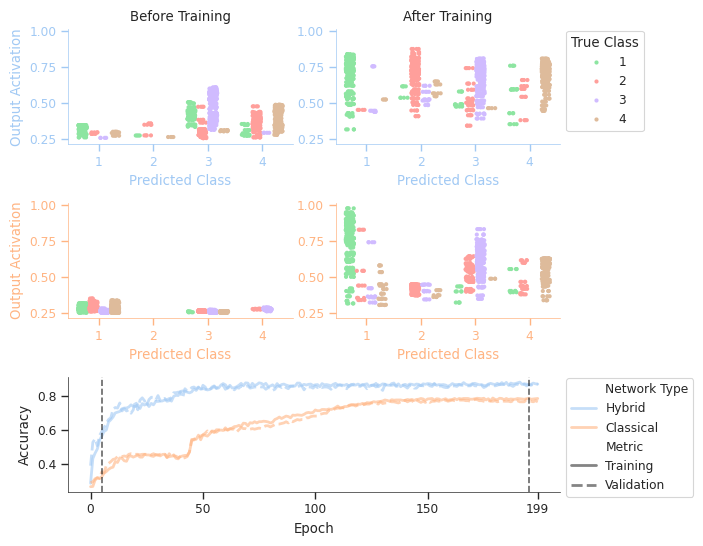

/tmp/ipykernel_2140670/721710077.py:119: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.


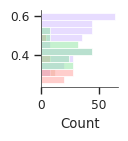

/tmp/ipykernel_2140670/721710077.py:128: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.


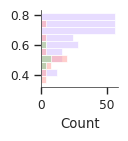

In [54]:
def set_edge_color(ax, color, style='-'):
    ax.tick_params(colors=color)
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linestyle(style)
    return

df_exp = copy.deepcopy(df_kerr8_all_weights)
df_exp = df_exp.loc[[1,309]]
df_exp.reset_index(inplace=True)
df_exp.drop(1, inplace=True)
df_exp = df_exp.explode(column=['acc', 'val_acc', 'loss', 'val_loss', 'epoch'])

df_exp = df_exp.melt(['network_type', 'n_layers', 'num_qumodes', 'num_params', 'cutoff', 'exp_folder', 'epoch'], ['acc', 'val_acc'], var_name='Metric', value_name='accuracy')
df_exp.loc[df_exp['Metric']=='acc', 'Metric'] = 'Training'
df_exp.loc[df_exp['Metric']=='val_acc', 'Metric'] = 'Validation'
df_exp.reset_index(inplace=True)
df_exp.pop('index')

fig = plt.figure(figsize=(6.5, 5.5))
gs = fig.add_gridspec(3, 2)
axs = [[],[]] 
axs[0].append(fig.add_subplot(gs[0,0]))
axs[1].append(fig.add_subplot(gs[1,0], sharex=axs[0][0], sharey=axs[0][0]))
for row in range(2):
    for col in range(1):
        axs[row].append(fig.add_subplot(gs[row,col+1], sharex=axs[0][0], sharey=axs[0][0]))
# axs[0].append(fig.add_subplot(gs[0,1], sharex=axs[0][0], sharey=axs[0][0]))
# axs[1].append(fig.add_subplot(gs[1,0], sharex=axs[0][0], sharey=axs[0][0]))
# axs[1].append(fig.add_subplot(gs[1,1], sharex=axs[0][0], sharey=axs[0][0]))
axs.append(fig.add_subplot(gs[2,:]))
dodge = True
jitter = 0.3
size = 3.0
palette_temp = palette[2:8]
x_var = 'pred_class'
y_var = 'pred_value'

ax0 = sns.stripplot(before_train_plot_df_kerr_melted[before_train_plot_df_kerr_melted['network_type']=='quantum'],
               x=x_var, 
               dodge=dodge, 
               jitter=jitter,
               y=y_var, 
               hue='true_class',
               palette=palette_temp,
               s=size,
               ax=axs[0][0],
               legend=None,
               native_scale=True)
ax1 = sns.stripplot(after_train_plot_df_kerr_melted[after_train_plot_df_kerr_melted['network_type']=='quantum'],
                x=x_var, 
                dodge=dodge, 
                jitter=jitter,
                y=y_var, 
                hue='true_class',
                palette=palette_temp,
                s=size,
                ax=axs[0][1],
                native_scale=True)
ax2 = sns.stripplot(before_train_plot_df_kerr_melted[before_train_plot_df_kerr_melted['network_type']=='classical'],
                    x=x_var,
                    dodge=dodge,
                    jitter=jitter,
                    y=y_var,
                    hue='true_class',
                    palette=palette_temp,
                    s=size,
                    ax=axs[1][0],legend=None, native_scale=True)
ax3 = sns.stripplot(after_train_plot_df_kerr_melted[before_train_plot_df_kerr_melted['network_type']=='classical'],
                    x=x_var,
                    dodge=dodge,
                    jitter=jitter,
                    y=y_var,
                    hue='true_class',
                    palette=palette_temp,
                    s=size,
                    ax=axs[1][1],legend=None, native_scale=True)


set_edge_color(axs[0][0], colors[0])
set_edge_color(axs[0][1], colors[0])
set_edge_color(axs[1][0], colors[1])
set_edge_color(axs[1][1], colors[1])
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1.04))
ax0.set_title('Before Training')
ax0.set_xlabel('Predicted Class', color=colors[0])
ax0.set_ylabel('Output Activation', color=colors[0])
ax1.set_xlabel('Predicted Class', color=colors[0])
ax1.set_ylabel('')
ax1.set_title('After Training')
ax2.set_xlabel('Predicted Class', color=colors[1])
ax2.set_ylabel('Output Activation', color=colors[1])
ax3.set_xlabel('Predicted Class', color=colors[1])
ax3.set_ylabel('')

ax1.legend_.set_title('True Class')

sns.despine()
ax4 = sns.lineplot(df_exp, x='epoch', y='accuracy', 
                   hue='network_type', style='Metric', 
                   hue_order=['quantum', 'classical'], 
                   alpha=0.6, markers=False,
                   dashes=True, ax=axs[2], lw=2)
handles, labels = ax4.get_legend_handles_labels()
labels = ['Hybrid' if l=='quantum' else 'Classical' if l=='classical' else l for l in labels]
labels = ['Network Type' if l=='network_type' else l for l in labels]
ax4.legend(handles=handles, labels=labels)
ax4.set_ylabel('Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_xticks([0, 50, 100, 150, 199])
plt.axvline(x=epoch_before, color='k', linestyle='--', alpha=0.6)
plt.axvline(x=epoch_after, color='k', linestyle='--', alpha=0.6)
plt.tight_layout()
sns.move_legend(ax4, loc='upper left', bbox_to_anchor=(1,1.04))
plt.savefig('./figures/quantum_classical_train_output.svg', dpi=300, bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(1,1,figsize=(1,1))

sns.histplot(before_train_plot_df_kerr_melted[(before_train_plot_df_kerr_melted['network_type']=='quantum') & (before_train_plot_df_kerr_melted['pred_class']==3)], y='pred_value', 
             hue='true_class', palette=palette_temp, stat='count', common_norm=True, ax=ax, legend=None)
ax.set_ylabel('')
sns.despine()
plt.savefig('./figures/before_train_output3_hist.svg', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(1,1))

sns.histplot(after_train_plot_df_kerr_melted[(after_train_plot_df_kerr_melted['network_type']=='quantum') & (after_train_plot_df_kerr_melted['pred_class']==3)], y='pred_value', 
             hue='true_class', palette=palette_temp, stat='count', common_norm=True, ax=ax, legend=None)
sns.despine()
ax.set_ylabel('')
plt.savefig('./figures/after_train_output3_hist.svg', dpi=300, bbox_inches='tight')
plt.show()



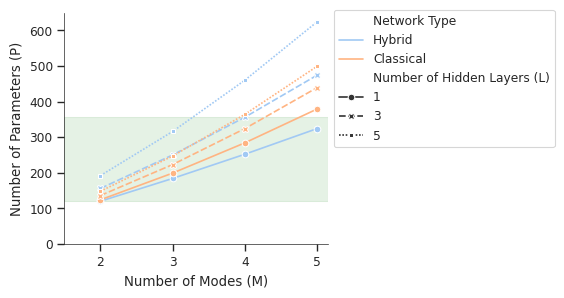

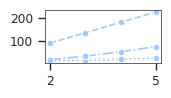

In [39]:
# Parameter scaling plots
n_layers = [1,3,5]
num_qumodes = [2,3,4,5]
num_params = [get_num_parameters_per_quantum_layer(n)*l + n*5*(8+1) + 4*(n+1) for n,l in product(num_qumodes, n_layers)]

param_df = pd.DataFrame(columns=['n_layers', 'num_qumodes', 'num_params', 'network_type', 'input_params', 'output_params', 'hidden_params'])
for nl in n_layers:
    for nq in num_qumodes:
        quantum_params = get_num_parameters_per_quantum_layer(nq)*(nl)
        input_params = nq*5*(8+1)
        output_params = 4*(nq+1)
        total_quantum = quantum_params + input_params + output_params
        param_df.loc[len(param_df)] = [nl, nq, int(total_quantum), 'quantum', input_params, output_params, int(quantum_params)]
        
        classical_params = nq*(nq*5+1)
        classical_params += nq*(nq+1)*(nl-1)
        total_classical = classical_params + input_params + output_params
        param_df.loc[len(param_df)] = [nl, nq, int(total_classical), 'classical', input_params, output_params, int(classical_params)]

fig, ax = plt.subplots(1,1, figsize=(3.4, 3))
ax1 = sns.lineplot(param_df, x='num_qumodes', y='num_params', hue='network_type', style='n_layers', palette=palette[0:2], markers=True, ax=ax)
input_output_df = param_df[(param_df['network_type']=='quantum') & (param_df['n_layers']==1)]

plt.axhspan(ymin=120, ymax=356, color='green', alpha=0.1)
ax1.set_xlabel('Number of Modes (M)')
ax1.set_ylabel('Number of Parameters (P)')
handles, labels = ax.get_legend_handles_labels()
labels = ['Classical' if l=='classical' else 'Hybrid' if l=='quantum' else l for l in labels]
labels = ['Network Type' if l=='network_type' else 'Number of Hidden Layers (L)' if l=='n_layers' else l for l in labels]
plt.legend(labels=labels, handles=handles)
plt.ylim(bottom=0)
plt.xlim(left=1.5)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1.04))
sns.despine()
plt.savefig('./figures/param_scaling.svg', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(1.5, 0.7))
sns.lineplot(input_output_df, x='num_qumodes', y='input_params', color=palette[0], marker='o', ls='--',ax=ax)
sns.lineplot(input_output_df, x='num_qumodes', y='output_params', color=palette[0], marker='o', ls=':', ax=ax)
sns.lineplot(input_output_df, x='num_qumodes', y='hidden_params', color=palette[0], marker='o', ls='-.', ax=ax)
plt.xticks([2,5])
plt.xlabel('')
plt.ylabel('')
plt.savefig('./figures/param_scaling_seperated.svg', bbox_inches='tight')
plt.show()

# Noise Analysis
Apply noise to the weights of the network and see how the accuracy changes.

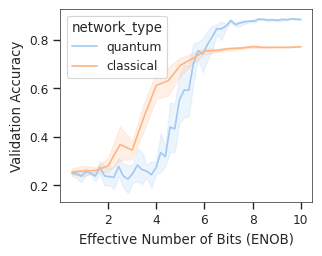

In [56]:
def get_intersection_index(df):
    df = df.groupby(['network_type', 'enob']).mean().reset_index()
    df_classical = df[df['network_type']=='classical']
    df_quantum = df[df['network_type']=='quantum']
    

df_kerr8_noise_2_qumode = pd.read_pickle('./dataframes/enob_df.pkl', compression='xz')
df_kerr8_noise_3_qumode = pd.read_pickle('./dataframes/enob_df_3qumode.pkl', compression='xz')
df_kerr8_noise_4_qumode = pd.read_pickle('./dataframes/enob_df_4qumode.pkl', compression='xz')

df_kerr8_noise_classical = pd.read_pickle('./dataframes/enob_df_1layer_classical.pkl', compression='xz')

df_kerr8_noise_2_qumode.drop(df_kerr8_noise_2_qumode[df_kerr8_noise_2_qumode['network_type']=='classical'].index, inplace=True)
df_kerr8_noise_2_qumode = pd.concat([df_kerr8_noise_2_qumode, df_kerr8_noise_classical], ignore_index=True)

df_kerr8_noise_2_qumode['acc_frac'] = 0
df_kerr8_noise_2_qumode.loc[df_kerr8_noise_2_qumode['network_type']=='quantum', 'acc_frac'] = (df_kerr8_noise_2_qumode.loc[df_kerr8_noise_2_qumode['network_type']=='quantum', 'val_acc'] / df_kerr8_noise_2_qumode.loc[df_kerr8_noise_2_qumode['network_type']=='quantum', 'val_acc'].max())
df_kerr8_noise_2_qumode.loc[df_kerr8_noise_2_qumode['network_type']=='classical', 'acc_frac'] = (df_kerr8_noise_2_qumode.loc[df_kerr8_noise_2_qumode['network_type']=='classical', 'val_acc'] / df_kerr8_noise_2_qumode.loc[df_kerr8_noise_2_qumode['network_type']=='classical', 'val_acc'].max())

fig, axs = plt.subplots(1,1, figsize=(3.25, 2.5), sharex=True, sharey=True)
ax1 = sns.lineplot(df_kerr8_noise_2_qumode, x='enob', y='val_acc', hue='network_type', ax=axs)
# ax2 = sns.lineplot(df_kerr8_noise_3_qumode, x='enob', y='val_acc', hue='network_type', ax=axs[1], legend=None)
# ax3 = sns.lineplot(df_kerr8_noise_4_qumode, x='enob', y='val_acc', hue='network_type', ax=axs[2])

ax1.set_xlabel('Effective Number of Bits (ENOB)')
ax1.set_xticks([2,4,6,8,10])
ax1.set_ylabel('Validation Accuracy')
# ax1.set_xlabel('')
# ax1.set_xticks([2,4,6,8,10])
# ax1.set_title('2 Qumodes')
# ax2.set_xlabel('Effective Number of Bits (ENOB)')
# ax2.set_title('3 Qumodes')
# ax3.set_xlabel('')
# ax3.set_title('4 Qumodes')
# ax1.set_ylabel('Validation Accuracy')
# ax2.set_ylabel('')
# ax3.set_ylabel('')
# handles, labels = ax3.get_legend_handles_labels()
# print(labels)
# labels = ['Classical' if l=='classical' else 'Hybrid' if l=='quantum' else l for l in labels]
# labels = ['Network Type' if l=='network_type' else 'Number of Hidden Layers (L)' if l=='n_layers' else l for l in labels]
# plt.legend(labels=labels, handles=handles, title='Network Type')
# #sns.move_legend(ax3, "upper left", bbox_to_anchor=(1, 1.04))
plt.savefig('./figures/enob_sweep.svg', bbox_inches='tight')
plt.show()

,amplitude_enob,phase_enob,val_acc,acc,loss,sample
0,0.5,0.5,0.001491,0.055608,0.355823,1.581139
1,0.5,1.0,0.093660,0.135153,0.449578,1.581139
2,0.5,1.5,0.001491,0.000000,0.295596,1.581139
3,0.5,2.0,0.000000,0.036631,0.515579,1.581139
4,0.5,2.5,0.000000,0.029388,0.574741,1.581139


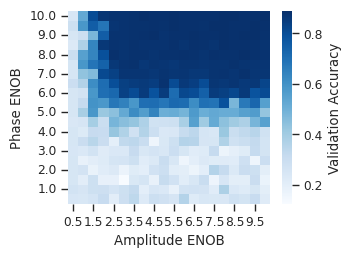

In [41]:
from scipy.interpolate import griddata

df_kerr8_noise_amp_phase_full = pd.read_pickle('./dataframes/enob_df_amp_phase_sweep_coarse_whole_numbers.pkl', compression='xz')
df_kerr8_noise_amp_phase = df_kerr8_noise_amp_phase_full[['amplitude_enob', 'phase_enob', 'val_acc', 'acc', 'loss', 'sample']]
df_kerr8_noise_amp_phase_std = df_kerr8_noise_amp_phase.groupby(['amplitude_enob', 'phase_enob']).std().reset_index()
df_kerr8_noise_amp_phase = df_kerr8_noise_amp_phase.groupby(['amplitude_enob', 'phase_enob']).mean().reset_index()
df_kerr8_noise_amp_phase = df_kerr8_noise_amp_phase.apply(pd.to_numeric, errors='coerce').round(3)
df_kerr8_noise_amp_phase.drop(['sample'], inplace=True, axis=1)
display(df_kerr8_noise_amp_phase_std.head())

fig, ax = plt.subplots(1,1, figsize=(3.25, 2.5))
ax1 = sns.heatmap(df_kerr8_noise_amp_phase.pivot(columns='amplitude_enob', index='phase_enob', values='val_acc')[::-1],
                  cmap='Blues', ax=ax,
                  cbar_kws={'label': 'Validation Accuracy'})
ax1.set_xlabel('Amplitude ENOB')
ax1.set_ylabel('Phase ENOB')
plt.savefig('./figures/amp_phase_enob_sweep.svg', bbox_inches='tight')
plt.show()


In [ ]:
sns.lineplot(df_kerr8[df_kerr8['network_type'=='quantum']], x='num_params', y='val_acc', hue='cutoff')